# **IS 4487 Week 6 - Data cleaning**

This notebook is designed to help you follow along with the Week 6 Lecture and Reading, introducing you to Python.

The practice code demos are intended to give you a chance to see working code and can be a source for your lap and assignment work. Each section contains short explanations and annotated code that reflect the steps in the reading.





### **Topics for this demo:**



*   Cleaning data (handling missing values, fixing formats, removing duplicates)
*   Data validation (ensure business rule compliance with the cleaned data)

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Demos/demo_06_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Context:**

StreamFlow, Inc. is a fast-growing streaming service that offers curated video content to
subscribers worldwide. The marketing analytics team has been tasked with building a customer
churn prediction model to identify users at risk of canceling their subscriptions. The dataset
includes customer demographics, subscription history, usage patterns, and account activity logs.

However, before modeling can begin, the team needs to clean and prepare the raw customer
data, which was pulled from multiple internal systems (CRM, billing, and user behavior
tracking). The dataset includes inconsistencies, missing values, and mixed data types.

### **Import Libraries**






In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


### **Load Dataframe**





In [ ]:
URL = 'https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/streamflow_customer_churn.csv'
df = pd.read_csv(URL)


### **Preliminary data inspection**





In [ ]:
df.head()

,customer_id,signup_date,age,gender,region,monthly_fee,total_streaming_hours,num_devices,plan_type,support_tickets_last_6mo,churned
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,2025-01-13,56.0,Non-binary,East,11.96,146.5,2,Standard,1,1
1,23b8c1e9-3924-46de-beb1-3b9046685257,2024-11-05,69.0,Male,West,9.11,111.7,5,Basic,0,0
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,2023-10-08,46.0,Female,South,11.54,100.6,3,Premium,0,0
3,972a8469-1641-4f82-8b9d-2434e465e150,2022-13-01,32.0,Male,East,18.48,169.3,2,Basic,2,0
4,17fc695a-07a0-4a6e-8822-e8f36c031199,2024-07-20,60.0,Male,South,8.04,49.0,5,Basic,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               250 non-null    object 
 1   signup_date               250 non-null    object 
 2   age                       238 non-null    float64
 3   gender                    240 non-null    object 
 4   region                    250 non-null    object 
 5   monthly_fee               250 non-null    float64
 6   total_streaming_hours     250 non-null    float64
 7   num_devices               250 non-null    int64  
 8   plan_type                 242 non-null    object 
 9   support_tickets_last_6mo  250 non-null    int64  
 10  churned                   250 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 21.6+ KB


In [ ]:
df.shape

(250, 11)

In [ ]:
df.describe()

,age,monthly_fee,total_streaming_hours,num_devices,support_tickets_last_6mo,churned
count,238.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,48.680672,12.906800,109.589200,2.912000,1.024000,0.248000
std,21.687630,3.949743,51.656826,1.445203,0.993667,0.432718
min,-10.000000,6.030000,10.500000,1.000000,0.000000,0.000000
25%,32.000000,9.562500,69.200000,2.000000,0.000000,0.000000
50%,47.500000,12.840000,111.800000,3.000000,1.000000,0.000000
75%,64.000000,16.310000,153.075000,4.000000,2.000000,0.000000
max,150.000000,19.950000,199.600000,5.000000,4.000000,1.000000


---
---
# **Cleaning data**

since our data is only 250 rows and our goal is to get it ready for machine learning, we will be dropping as few rows as possible and imputing missing data






---
### **Change the columns into their proper datatypes**

In [ ]:
categorical_cols = ['gender', 'region', 'plan_type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')


---
### **Look for missing values**







In [ ]:
df.isnull().sum()

,0
customer_id,0
signup_date,8
age,12
gender,10
region,0
monthly_fee,0
total_streaming_hours,0
num_devices,0
plan_type,8
support_tickets_last_6mo,0


had we not converted the datatypes we wouldn't have known we have 8 missing signup_date values

---
### **Look for duplicate rows**

In [ ]:
print(f' Number of duplicate rows: {df.duplicated().sum()}')

 Number of duplicate rows: 0


---
### **Look for formatting issues in the categorical columns**

In [ ]:
print('Looking for typos/formatting issues in the data:')
for cats in categorical_cols:
  print(f'{cats}:  {df[cats].unique()}')

Looking for typos/formatting issues in the data:
gender:  ['Non-binary', 'Male', 'Female', NaN]
Categories (3, object): ['Female', 'Male', 'Non-binary']
region:  ['East', 'West', 'South', 'North']
Categories (4, object): ['East', 'North', 'South', 'West']
plan_type:  ['Standard', 'Basic', 'Premium', NaN]
Categories (3, object): ['Basic', 'Premium', 'Standard']


---
###**Cleaning up the missing dates**

We will fill in the missing dates from known dates in a linear order. Basically Y=mx + B where you draw a line between two known points

In [ ]:
df['signup_date'] = df['signup_date'].interpolate(method='linear')

missing_date_check = df['signup_date'].isnull().sum()
print(f"the number of missing dates is: {missing_date_check}")


the number of missing dates is: 0


---
###**Eliminating invalid ages**

Earlier when we used df.describe() we saw that we had a minimum age of -10 and a maximum of 150 and we are missing 12 values.

First lets look at the distribution of age to decide what method of imputation we should use to fill the missing values (Mean, Median, Mode)


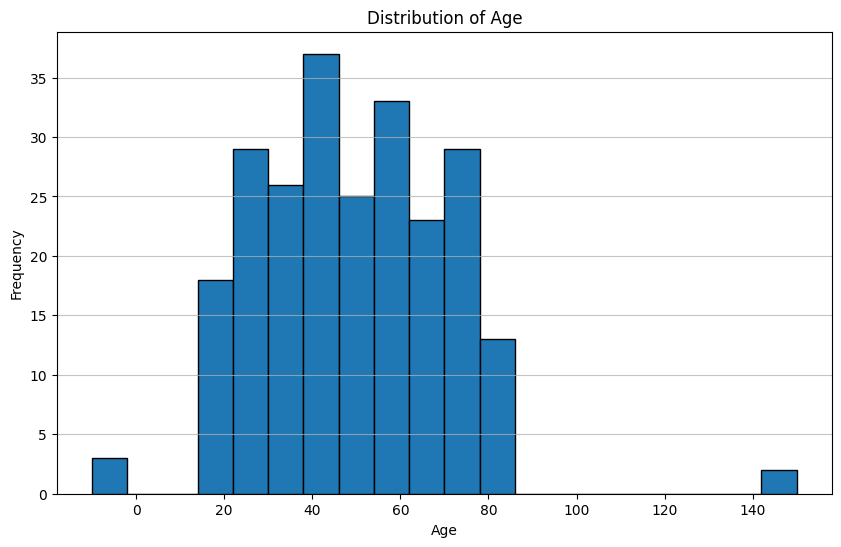

In [ ]:
# Plot a histogram of the age distribution
plt.figure(figsize=(10, 6))
plt.hist(df['age'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.grid(axis='y', alpha=0.75)
plt.show()

Ignoring the outliers we have a normal distribution, from here we can mark the outliers as NaN and fill in the NaN values with the median age. We chose to median imputation because using the median is more robust than the mean and wont be as affected by remaining edge cases

In [ ]:
# Filter out ages less than 18 or greater than 120
df.loc[(df['age'] < 18) | (df['age'] > 120), 'age'] = np.nan

# Step 2: Impute all NaN ages with median
df['age'] = df['age'].fillna(df['age'].median()).round().astype(int)

---
###**filling in missing values for gender**

We have 10 missing values for gender, we could impute the data using mean/median/mode but the drawback would be that we could skew our distrubtion throwing off a machine learning model. Lets look at the distribuition first

In [ ]:
# find gender distribution
gender_dist = df['gender'].value_counts(normalize=True)
print(gender_dist)

gender
Female        0.341667
Male          0.329167
Non-binary    0.329167
Name: proportion, dtype: float64


Since the distribution is essentially 33% for each category, a mode imputation would skew the gender distribution too heavily. We could drop the rows here but, since we are trying to preserve as much data as possible we will replace the NaN values with "unknown"  

We will encode gender later to get the dataset ready for machine learning.

In [ ]:
# Add 'Unknown' as a new category to the 'gender' column
df['gender'] = df['gender'].cat.add_categories('Unknown')

# Fill missing values in the 'gender' column with 'Unknown'
df['gender'] = df['gender'].fillna('Unknown')

# Print the value counts to verify the changes
print(df['gender'].value_counts(dropna=False))

gender
Female        82
Male          79
Non-binary    79
Unknown       10
Name: count, dtype: int64


Why didn't we impute gender using some ML tools? The reason We chose not to impute missing gender values with machine learning because predicting sensitive attributes could introduce bias and create ethical concerns. Instead, we created an "Uknown" category, which preserves all rows and allows the model to learn if missingness itself is a signal of disengagement or churn. This approach avoids false assumptions while still providing potentially valuable insights for business decision-making.

---
###**filling in missing values for plan type**

Imputing missing values for the plan type may be very intuitinve becuase we can assume that their is a relationship between plan_type and Monthly_fee.

We may be able to use regression based on monthly_fee to classify plan_types

lets look at the data by plan type and see if there is an obvoius range for plan type and monthly_fee that would allow us to impute the missing values


plan_type
Basic       12.742209
Premium     12.505921
Standard    13.387750
Name: monthly_fee, dtype: float64


/tmp/ipython-input-1994126785.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('plan_type')['monthly_fee'].mean())


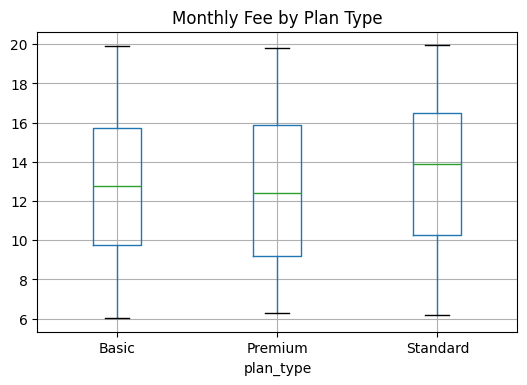

In [ ]:
# Group means
print(df.groupby('plan_type')['monthly_fee'].mean())

# Boxplot visualization
df.boxplot(column='monthly_fee', by='plan_type', figsize=(6,4))
plt.title("Monthly Fee by Plan Type")
plt.suptitle("")
plt.show()


Looking at this boxplot, we can see that the monthly fees for Basic, Premium, and Standard customers overlap heavily. None of the plan types has a clearly distinct fee range, which means we cannot reliably use monthly fee (or related variables) to predict the missing plan types. Because of this overlap, the best approach is to treat missing plan types as "unknown" , allowing our machine learning model to decide if missingness itself carries predictive power.

In [ ]:
# create a new category for plan_type to for NaNs
df['plan_type'] = df['plan_type'].cat.add_categories(['Unknown'])

#Impute NaNs with "unknown"
df['plan_type'] = df['plan_type'].fillna('Unknown')


---
### **Final Steps**

We are going to copy the changes we made in our dataframe to a machine learning ready data frame.

We will drop the customer_id column beucase it serves no purpose for machine learning, check to make sure there are no missing values one last time, and take a quick glance at the machine learning ready dataframe

In [ ]:
# Make a copy for ML
df_ML_ready = df.copy()

# Drop ID column
df_ML_ready = df_ML_ready.drop(columns=['customer_id'])

#check for NaN values
df_ML_ready.isnull().sum()

,0
signup_date,0
age,0
gender,0
region,0
monthly_fee,0
total_streaming_hours,0
num_devices,0
plan_type,0
support_tickets_last_6mo,0
churned,0


In [ ]:
df_ML_ready.head()


,signup_date,age,gender,region,monthly_fee,total_streaming_hours,num_devices,plan_type,support_tickets_last_6mo,churned
0,2025-01-13,56,Non-binary,East,11.96,146.5,2,Standard,1,1
1,2024-11-05,69,Male,West,9.11,111.7,5,Basic,0,0
2,2023-10-08,46,Female,South,11.54,100.6,3,Premium,0,0
3,2024-02-28,32,Male,East,18.48,169.3,2,Basic,2,0
4,2024-07-20,60,Male,South,8.04,49.0,5,Basic,1,0


---
### **Final Note**

From here you would potentially need to:
* convert plan_type, region, and gender into string datatypes for some machine learning tools, or keep them as objects for other machine learning tools
* Encode these categorical variables so machine learning models can work with them

In this example our main goal was to show how to clean data and missing values without losing rows from the dataset.